<a href="https://colab.research.google.com/github/LUMII-AILab/NLP_Course/blob/main/notebooks/HFST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galīgo automātu lietojums morfoloģijā | Finite state automata for morphology

Helsinki Finite State Transdusers (HFST)

Skat. arī.: https://github.com/hfst/compmorph-course/tree/v1.0

In [10]:
!pip install hfst
# !pip install hfst_dev
#!pip install graphviz

In [11]:
import hfst
# import hfst_dev
#import graphviz
from IPython.display import Image

In [12]:
# help(hfst)
# help(hfst.compile_lexc_file)
# help(hfst.compile_twolc_file)

## Leksikona izveide

Leksikona veido:
1. Saraksts ar vairāksimbolu virknēm, ko izmanto FST aprakstīta morfoloģija (Multichar_Symbols)
2. Sakņu/celmu/morfēmu leksikons (LEXICON)
3. Morfotaktika (piemērā LEXICON N4dekl)

Simbols "!" tiek lietots kā komentāra simbols

```
Multichar_Symbols
        +N      ! Noun tag
        +Sg     ! Singular
        +Pl     ! Plural
        +Nom
        +Gen
        +Dat
        +Acc
        +Loc

!Define root lexicon
LEXICON Root
  Nouns ; ! No input, no output

!Define noun lexicon
LEXICON Nouns
  rok N4dekl ;

! Define 4th declension paradigm
LEXICON N4dekl
+N+Sg+Nom:^a  # ;
+N+Sg+Gen:^as # ;
+N+Sg+Dat:^ai # ;
+N+Sg+Acc:^u # ;
+N+Sg+Loc:^ā # ;
+N+Pl+Nom:^as  # ;
+N+Pl+Gen:^u  # ;
+N+Pl+Dat:^ām # ;
+N+Pl+Acc:^as # ;
+N+Pl+Loc:^ās # ;

```



In [13]:
# Leksikona augšuplāde no faila
!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/HFST/Latvian.lexc
#!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/HFST/roka.lexc

--2025-03-05 13:49:04--  https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/HFST/Latvian.lexc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541 [text/plain]
Saving to: ‘Latvian.lexc.1’

Latvian.lexc.1      100%[===================>]     541  --.-KB/s    in 0s      

2025-03-05 13:49:04 (25.8 MB/s) - ‘Latvian.lexc.1’ saved [541/541]



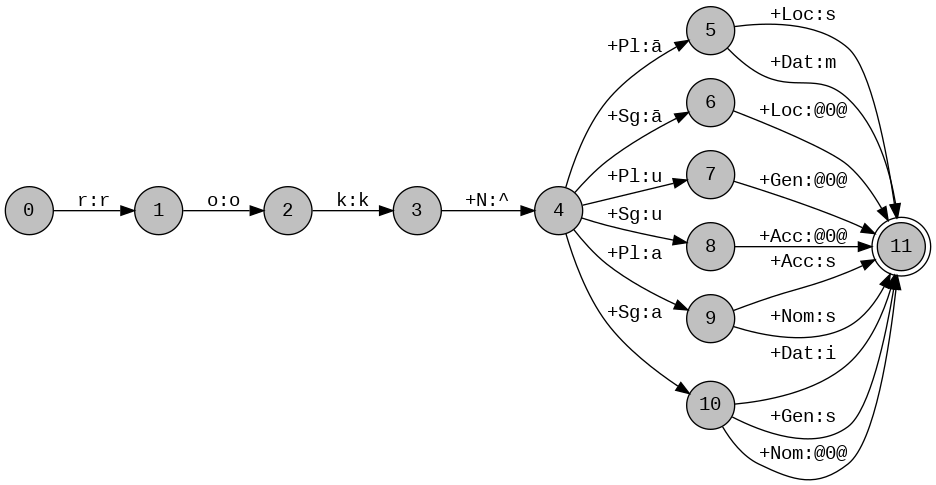

In [14]:
from hfst import compile_lexc_file
generator = hfst.compile_lexc_file('Latvian.lexc')
#generator = hfst.compile_lexc_file('roka.lexc')
#generator = hfst.compile_lexc_file('maja.lexc')
print(generator.lookup('rok+N+Sg+Loc'))
# print (generator)


(('rok^ā@_EPSILON_SYMBOL_@', 0.0),)


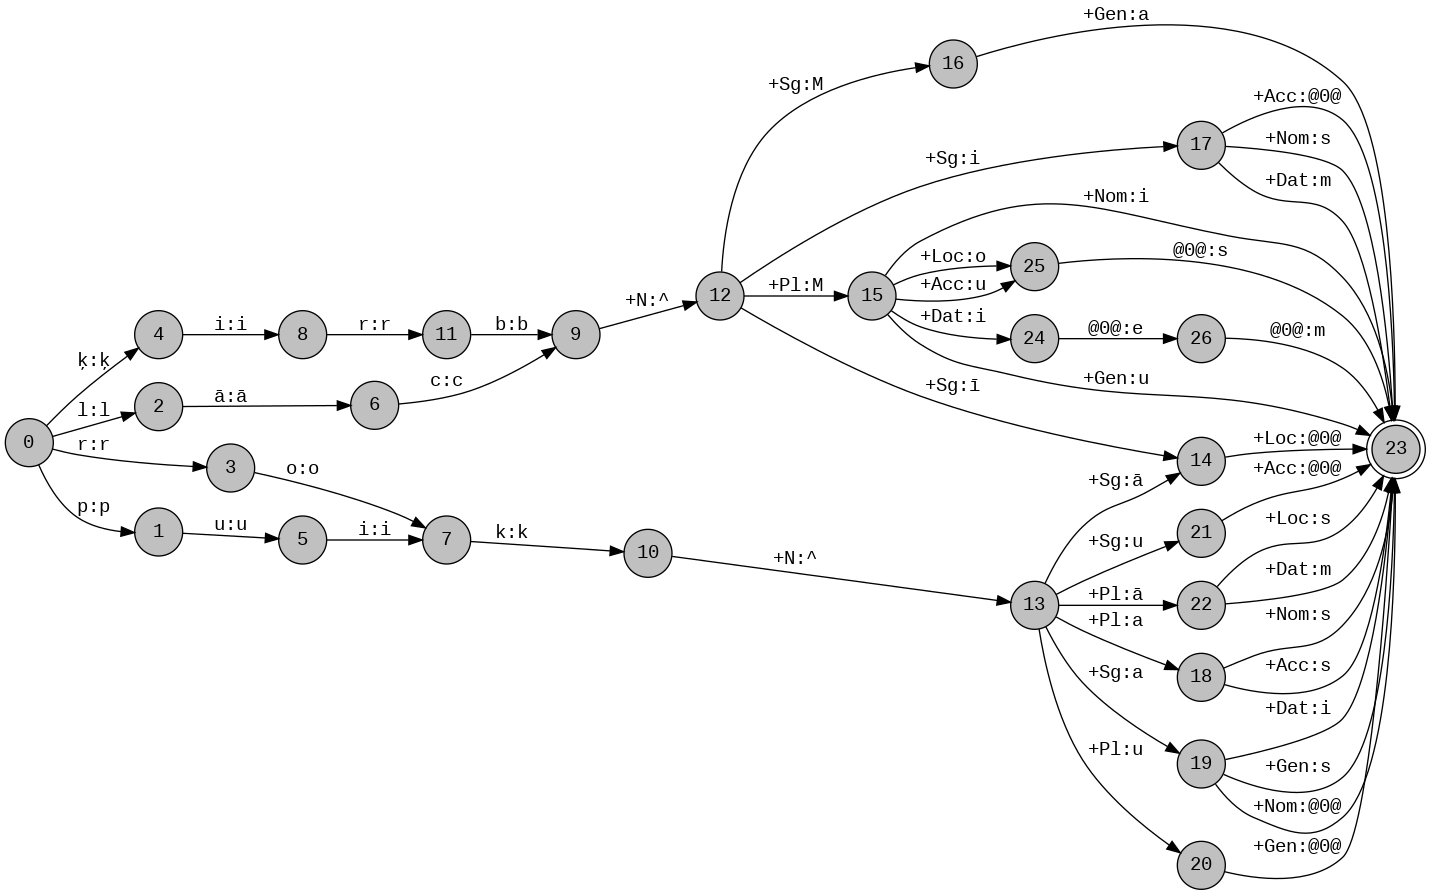

In [15]:
# Vizualizācija
hfst2png(generator,'generator.png')
Image('generator.png')

## Transdjūseri: divlīmeņu morfoloģija | Transducers: two-level morphology


In [16]:
# Sintēze | Synthesis
from hfst import HfstTransducer

analyzer = HfstTransducer(generator) # Create a copy

print(analyzer.lookup('rok+N+Sg+Nom'))

(('rok^a@_EPSILON_SYMBOL_@', 0.0),)


In [17]:
# Analīze | Analysis
# We need to invert the transducer to get an analyzer.
# After inversion, it is good to minimize the transducer
# (i.e. reduce it to an equivalent transducer with the smallest number of states).

analyzer.invert()
analyzer.minimize()

print(analyzer.lookup('rok^ā'))

(('rok+N+Sg+Loc', 0.0),)


In [18]:
# Salīdzināšana | Comparison

analyzer.invert()
analyzer.minimize()

print(analyzer.compare(generator))

True


## FST kaskadēšana | FST cascading

Pārveidošanas likumi:

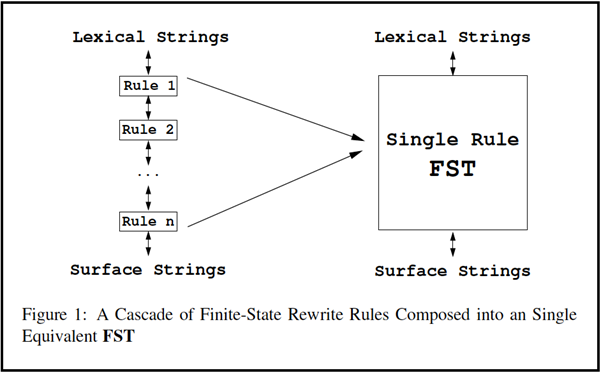

In [19]:
from hfst import regex, HfstTransducer

### Iespraušana

In [20]:
# Insertion
InsertJ = hfst.regex('[..] -> j || [b | f | m | p | v] _ "^" M')
print(InsertJ.lookup("ķirb^Ma'"))

(("ķirbj^Ma'", 0.0),)


### Aizstāšana

In [21]:
# Replacement
CReplacement = hfst.regex('c -> č ||  _ "^" M')
print(CReplacement.lookup("lāc^Ma'"))

(("lāč^Ma'", 0.0),)


### Izņēmumi

In [22]:
# Exceptions
#Exceptions = hfst.regex('[[{puik} "+N" "+Sg" "+Dat" .x. {puikam}] ]')
Exceptions = hfst.regex('a i-> a m || p u i k "^"  _')
print(Exceptions.lookup("puik^ai"))

(('puik^am', 0.0),)


### Dzēšana

In [23]:
# Deleting
MCleanup = hfst.regex('M -> 0')
Cleanup = hfst.regex('"^" -> 0')
print(MCleanup.lookup("lāč^Ma'"))

(("lāč^@_EPSILON_SYMBOL_@a'", 0.0),)


## FST apvienošana | FST composition

In [24]:
from hfst import compose

# Sintēze | Generation
cascade = compose((generator, InsertJ, CReplacement, Exceptions, MCleanup, Cleanup))
print(cascade.lookup("rok+N+Pl+Loc"))
print(cascade.lookup("puik+N+Sg+Dat"))

(('rok@_EPSILON_SYMBOL_@ās', 0.0),)
(('puik@_EPSILON_SYMBOL_@am', 0.0),)


In [25]:
# If you use the HFST library, you will need to remove the epsilon symbol.
cascade.remove_epsilons()
print(cascade.lookup("rok+N+Pl+Loc")[0][0].replace("@_EPSILON_SYMBOL_@", ""))

rokās


In [26]:
# Analīze | Analysis
inv = hfst.HfstTransducer(cascade)
inv.invert()
inv.convert(hfst.ImplementationType.HFST_OL_TYPE)
print(inv.lookup("rokās"))
print(inv.lookup("puikam"))

(('rok+N+Pl+Loc', 0.0),)
(('puik+N+Sg+Dat', 0.0),)


## FST vizualizācija | FST visualization

In [27]:
import sys

def hfst2png(transducer, png_name):
    # Write the FST to a file using the att format
    f = open("a.att", "w", encoding="utf-8")
    transducer.minimize()
    transducer.write_att(f, False)

    # Convert the FST file to the dot format
    # dot format is used by graphviz library for graph visualization
    f = open("a.att", "r", encoding="utf-8")
    with open("graph.dot", "w", encoding="utf-8") as out_f:
        out_f.write('digraph G { rankdir="LR"\n')
        out_f.write('node [fontname="Tahoma",shape=circle,fontsize=14,fixedsize=true,fillcolor="grey",style=filled]\n')
        out_f.write('edge [fontname="FreeMono",fontsize=14]\n')
        for line in f.readlines():
            line = line.strip()
            row = line.split('\t')
            if len(row) >= 4:
                out_f.write('%s [label="%s"];\n' % (row[0], row[0]))
                out_f.write('%s -> %s [label="%s:%s"];\n' % (row[0], row[1], row[2], row[3]))
            elif len(row) == 1: # Final state
                out_f.write('%s [label="%s",shape=doublecircle];\n' % (row[0], row[0]))
        out_f.write('}')

    # Call graphviz dot function to generate a png file from dot file
    !dot -Tpng graph.dot > $png_name

In [28]:
# Call the transformation to png on the HFSTTransducer "cascade"
hfst2png(cascade,'image.png')

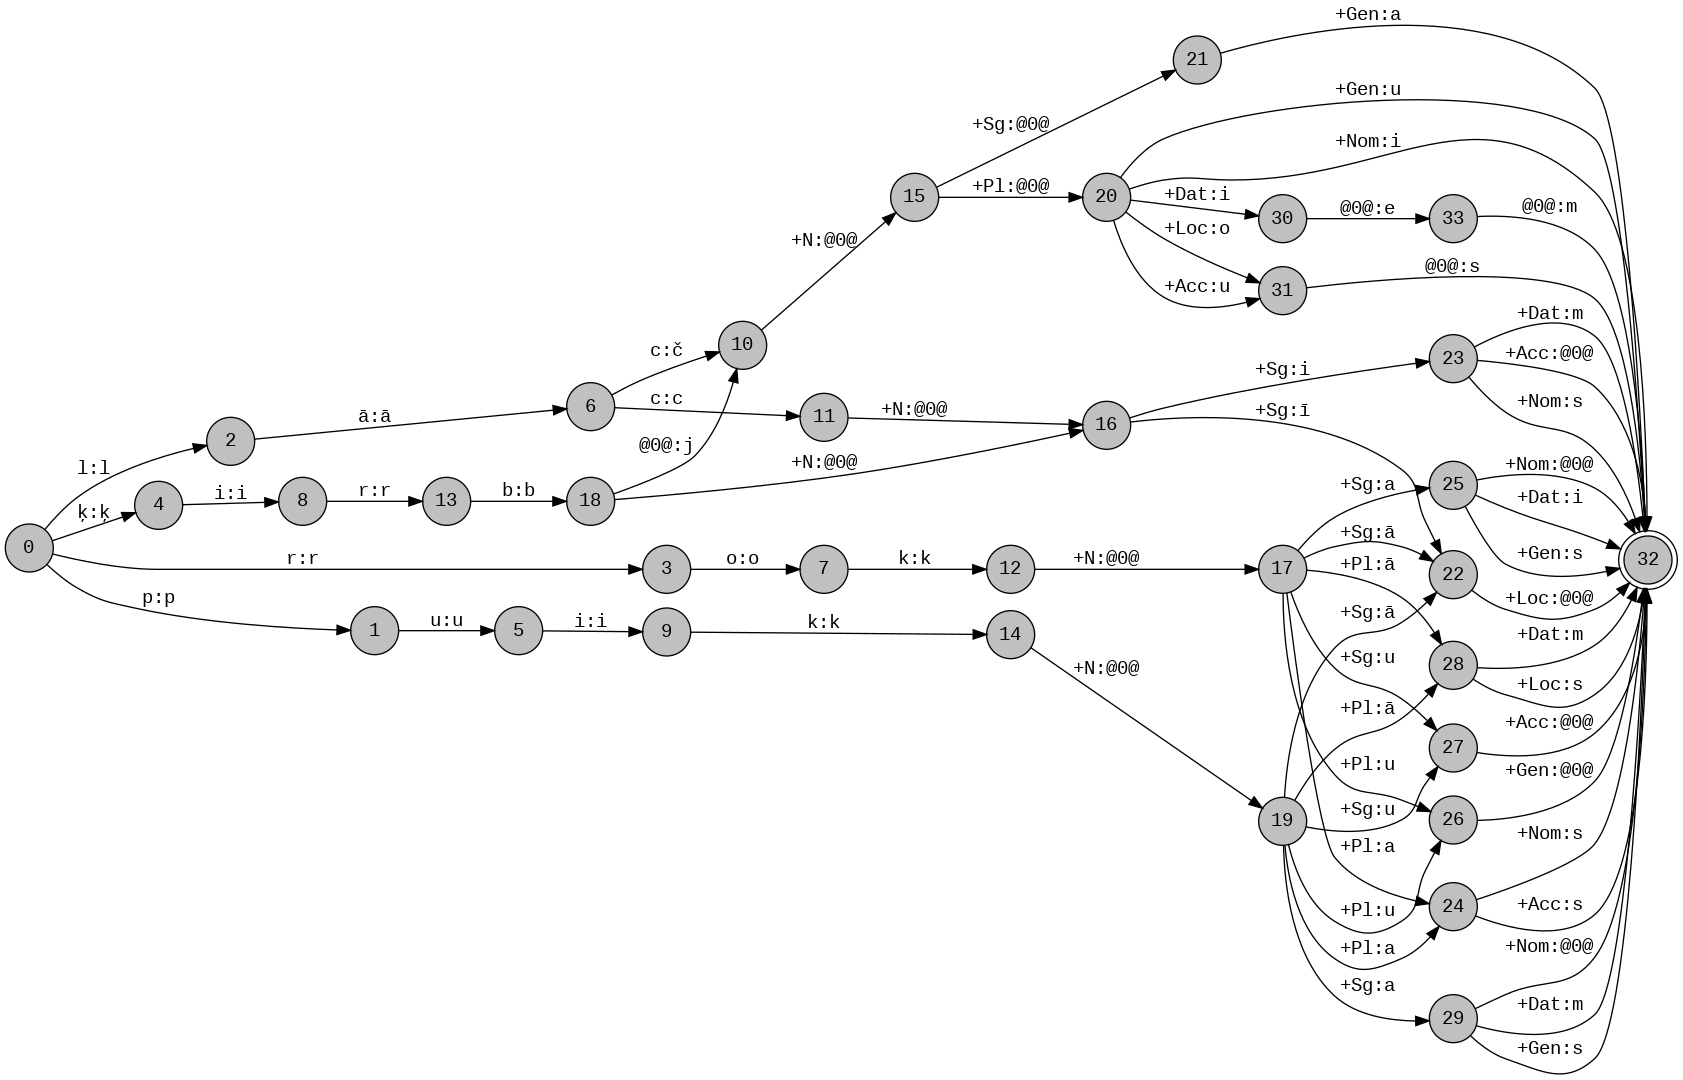

In [29]:
# Display image in notebook
# from IPython.display import Image
Image('image.png')

Izdrukāšana

In [30]:
for noun in ["rok", "puik", "ķirb", "lāc"]:
    for number in ["Sg", "Pl"]:
        for form in ["Nom", "Gen", "Dat", "Acc", "Loc"]:
            print(noun + "+N+" + number + "+" + form + " - " + cascade.lookup(noun + "+N+" + number + "+" + form)[0][0].replace("@_EPSILON_SYMBOL_@", ""))




rok+N+Sg+Nom - roka
rok+N+Sg+Gen - rokas
rok+N+Sg+Dat - rokai
rok+N+Sg+Acc - roku
rok+N+Sg+Loc - rokā
rok+N+Pl+Nom - rokas
rok+N+Pl+Gen - roku
rok+N+Pl+Dat - rokām
rok+N+Pl+Acc - rokas
rok+N+Pl+Loc - rokās
puik+N+Sg+Nom - puika
puik+N+Sg+Gen - puikas
puik+N+Sg+Dat - puikam
puik+N+Sg+Acc - puiku
puik+N+Sg+Loc - puikā
puik+N+Pl+Nom - puikas
puik+N+Pl+Gen - puiku
puik+N+Pl+Dat - puikām
puik+N+Pl+Acc - puikas
puik+N+Pl+Loc - puikās
ķirb+N+Sg+Nom - ķirbis
ķirb+N+Sg+Gen - ķirbja
ķirb+N+Sg+Dat - ķirbim
ķirb+N+Sg+Acc - ķirbi
ķirb+N+Sg+Loc - ķirbī
ķirb+N+Pl+Nom - ķirbji
ķirb+N+Pl+Gen - ķirbju
ķirb+N+Pl+Dat - ķirbjiem
ķirb+N+Pl+Acc - ķirbjus
ķirb+N+Pl+Loc - ķirbjos
lāc+N+Sg+Nom - lācis
lāc+N+Sg+Gen - lāča
lāc+N+Sg+Dat - lācim
lāc+N+Sg+Acc - lāci
lāc+N+Sg+Loc - lācī
lāc+N+Pl+Nom - lāči
lāc+N+Pl+Gen - lāču
lāc+N+Pl+Dat - lāčiem
lāc+N+Pl+Acc - lāčus
lāc+N+Pl+Loc - lāčos
